In [63]:
!pip install plotly
!pip install ggplot
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from ggplot import *
plotly.tools.set_credentials_file(username='willcuratolo', api_key='dCizVSpAQc5MhQ8KDKTn')

I was recently in New York City and found myself travelling all across town.  It is, of course, a huge city, and most people get around using public transportation.  However, the subway and buses can be inconvenient, especially on days like when I was there when it was cold and rainy.  I didn't want to walk half a mile to a subway stop, spend an hour on a cold subway, and then walk another half mile to my destination.  So I did what anyone would do and pulled out my phone to call an Uber or Lyft.  Of course, everyone else was thinking the same thing, so prices were high.  If only there was some other way!  Of course, the NYC yellow cab has been a ubiquitous fixture of the city for a long time.  I actually caught a cab, and it was cheaper than the Uber would have been, and it was convenient and clean.  The nice thing about official taxis is that they are government regulated.  This is nice for riders because hopefully it will be a more consistent experience.  However, it is nice for data scientists because it means their data is publicly available!  In this project I will be exploring NYC yellow cab data.

First lets check out the size of the data set.  This is only for the year 2015, and its 19GB.

In [12]:
%%bq dryrun
SELECT *
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
LIMIT 20

# Average Trip Length
I want to start by examining some basic facts about the dataset.  Such as, what is the average length of a taxi's trip?

In [17]:
%%bq query
SELECT DATE(pickup_datetime) AS date, AVG(trip_distance) AS avg_trip_distance
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
GROUP BY 1
ORDER BY 2

date,avg_trip_distance
2015-02-07,-79.93866944453573
2015-02-05,-67.36224298862236
2015-03-23,-41.63544842744909
2015-01-27,2.222634833948339
2015-01-07,2.6289844362776464
2015-01-26,2.6330668606544916
2015-01-08,2.644601392708242
2015-01-17,2.668375951865143
2015-02-21,2.668770341117994
2015-01-13,2.670525331258348


This is really odd.  What would a negative trip distance mean? Clearly there is some issues with this data. Starting on January 1, 2015, the price per mile of a yellow cab ride was \$2.50.  There are also other fees like a base fee, waiting time fees and more.  However, lets try to filter out all the erroneous trips.  Using this price information, we can say it is fair to assume that the price per mile of a legitimate cab ride would definitely be betwen \$2.50 and \$15.00 per mile.  So if we restrict the data to that range, what happens?

In [103]:
%%bq query --name avg_trip_distance_cleaned
SELECT DATE(pickup_datetime) AS date,  AVG(trip_distance) AS avg_trip_distance
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE fare_amount / (trip_distance + 0.0001) BETWEEN 2.5 AND 15
GROUP BY 1
ORDER BY 1

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



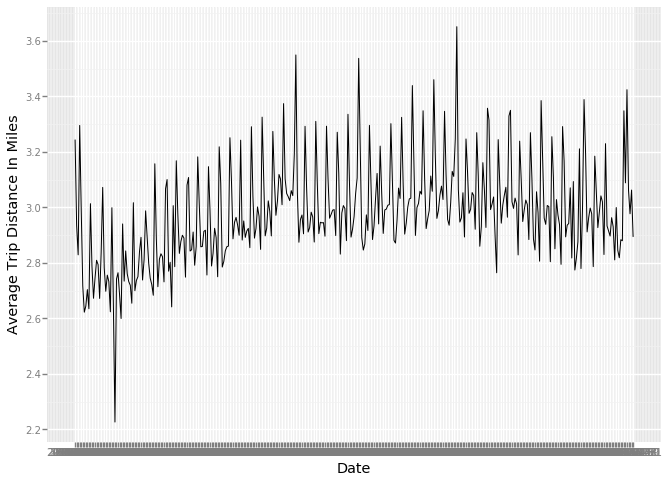

<ggplot: (8769356615421)>

In [107]:
avg_trip_df = avg_trip_distance_cleaned.execute(output_options=bq.QueryOutput.dataframe()).result()
ggplot(avg_trip_df, aes('date', 'avg_trip_distance')) + \
    geom_line() +\
    labs(x = "Date", y = "Average Trip Distance In Miles")

This looks a lot better.  The average trip distance for each day is between 2.2 miles and 3.7 miles.  In the earlier data, the trip distance is shorter than later.  This could probably be explained because of the fact that winter in New York can be brutal, and so people are willing to pay a little more to take a cab and escape the cold (just like I was - and I was only there in early November!).  But what are the frequent peaks and valleys?  Could it have to do with the weekday/weekend cycle?  Let's explore further.  First, we have to extract which day of the week it is from the date. Luckily Pandas can help us with that with the datetime data structure and a quick lambda function.

In [55]:
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

avg_trip_df['date'] = pd.to_datetime(avg_trip_df['date'])
avg_trip_df['day_of_week'] = avg_trip_df['date'].dt.dayofweek
avg_trip_df['day_of_week'] = avg_trip_df['day_of_week'].apply(lambda x: days[x])
avg_trip_df.sort_values(by = ['avg_trip_distance'], ascending = False)

,date,avg_trip_distance,day_of_week
249,2015-09-07,3.651236,Monday
144,2015-05-25,3.549415,Monday
185,2015-07-05,3.537089,Sunday
234,2015-08-23,3.460285,Sunday
220,2015-08-09,3.439142,Sunday
360,2015-12-27,3.424195,Sunday
332,2015-11-29,3.388739,Sunday
304,2015-11-01,3.384907,Sunday
136,2015-05-17,3.374058,Sunday
269,2015-09-27,3.357415,Sunday


So it seems like mostly Sundays are the longest days.  Now we want to group by the day of the week and see if there is any actual discrepancy of the means.

In [58]:
avg_trip_df.groupby('day_of_week', as_index=False)['avg_trip_distance'].mean().sort_values(by = ['avg_trip_distance'], ascending = False)

,day_of_week,avg_trip_distance
3,Sunday,3.233015
1,Monday,3.071252
0,Friday,2.962431
4,Thursday,2.954762
6,Wednesday,2.905840
5,Tuesday,2.877880
2,Saturday,2.868292


Interestingly, Sunday is the day with by far the longest average trip, and the rest are all fairly closely grouped but Saturday is the shortest.

# Average Speed
New York City traffic is notoriously stop and start (though perhaps Atlanta's is just as bad!).  When is the worst time to take a cab?

In [35]:
%%bq query --name avg_speed
SELECT TIME_TRUNC(TIME(pickup_datetime), HOUR) AS hour, AVG(trip_distance/((TIME_DIFF(TIME(dropoff_datetime), TIME(pickup_datetime), HOUR)))) AS avg_speed
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE fare_amount/(trip_distance+0.00001) BETWEEN 2.5 AND 15
  AND TIME_DIFF(TIME(dropoff_datetime), TIME(pickup_datetime), HOUR) > 0
  GROUP BY 1
  ORDER BY 1

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



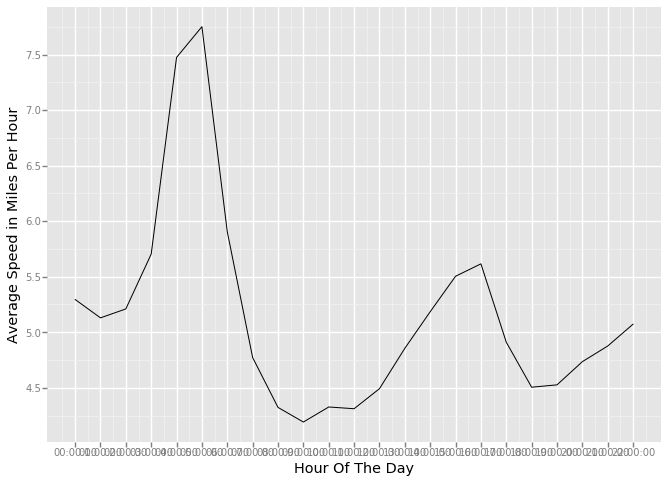

<ggplot: (8769361070824)>

In [106]:
avg_speed_df = avg_speed.execute(output_options=bq.QueryOutput.dataframe()).result()
ggplot(avg_speed_df, aes('hour', 'avg_speed')) + \
    geom_line() +\
    labs(x = "Hour Of The Day", y = "Average Speed in Miles Per Hour")

# Drop Off Points
Finally, I want to visualize where the most popular drop off locations are.

In [91]:
%%bq query --name popular_dropoffs
SELECT ROUND(dropoff_latitude, 4) as latitude, ROUND(dropoff_longitude, 4) as longitude, COUNT(*) as dropoffs 
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
GROUP BY latitude, longitude

In [92]:
popular_dropoffs_df = popular_dropoffs.execute(output_options=bq.QueryOutput.dataframe()).result()

Lets examine the most popular trips.

In [93]:
popular_dropoffs_df.sort_values(by = ['dropoffs'], ascending = False).head()

,latitude,longitude,dropoffs
403190,0.0000,0.0000,2212402
185198,40.7504,-73.9947,44626
337172,40.7501,-73.9949,40946
287957,40.7684,-73.8618,31819
298889,40.7606,-74.0027,31332


There are over 2 million trips dropped off at (0,0), but we know this cannot be the case.  This must be what happens when the latitude and longitude data is not correctly recorded.  But what about the drop off point with latitude 40.7504 and longitude -73.9947?  Where is that?  To find out, lets use the Plotly and Mapbox APIs.

In [94]:
mapbox_access_token = 'pk.eyJ1Ijoid2lsbGN1cmF0b2xvIiwiYSI6ImNqb25sZWlobzEzZXczcG80Mzdnd3JuOTQifQ.JCYLDqeJ2TdZf5cXj0E4xA'

data = [
    go.Scattermapbox(
        lat=['40.7504'],
        lon=['-73.9947'],
        mode='markers',
        marker=dict(
            size=14
        ),
        text=['Most Popular Dropoff Point'],
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.7504,
            lon=-73.9947
        ),
        pitch=0,
        zoom=15
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='NYC1')

That looks like Penn station.  Lets put the top ten (but skipping that first, erroneous entry) on the same map.

In [97]:
df_slice = popular_dropoffs_df.sort_values(by = ['dropoffs'], ascending = False)[1:11]
latitudes = list(df_slice['latitude'])
longitudes = list(df_slice['longitude'])

In [98]:

data = [
    go.Scattermapbox(
        lat=latitudes,
        lon=longitudes,
        mode='markers',
        marker=dict(
            size=14
        ),
        text=['Most Popular Dropoff Point', '2nd Most Popular',
             '3rd Most Popular', '4th Most Popular',
             '5th Most Popular', '6th Most Popular',
             '7th Most Popular', '8th Most Popular',
             '9th Most Popular', '10th Most Popular',
             ],
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.7504,
            lon=-73.9947
        ),
        pitch=0,
        zoom=11
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='NYC2')

So we see a lot of points around Penn Station, LaGuardia Airport, and the Ferry center on the West side of Manhattan. Finally, lets put all the drop off points on one plot and see what happens.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



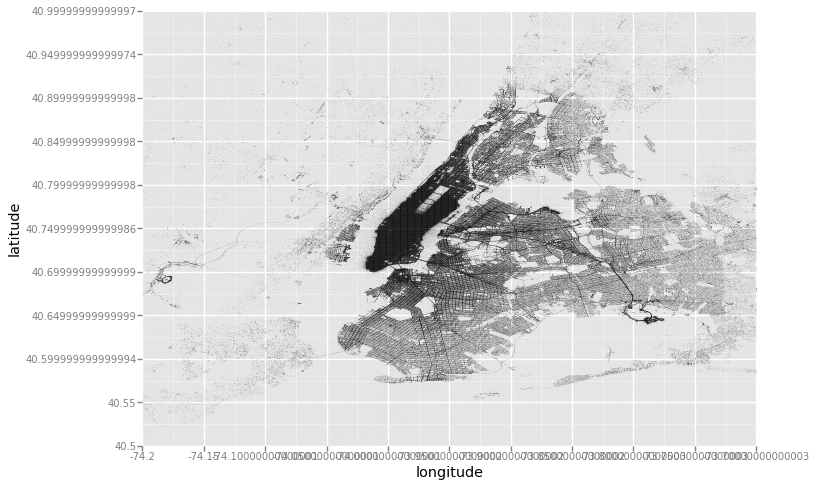

<ggplot: (-9223363267498490922)>

In [111]:
ggplot(popular_dropoffs_df,aes(x='longitude',y='latitude')) + \
  geom_point(size=0.01, alpha=0.1) + \
  xlim(-74.2, -73.7) + ylim(40.5, 41)

We can clearly see the city of New York.  Remember, no outline of the city itself or any map was plotted in this.  The drop off points themselves naturally form a picture of the city.  Of course, mid and lower Manhattan are the darkest, indicating the most frequent drop offs.  We also see very dark areas in the near neighborhoods in Brooklyn, Queens, and Jersey City across the river.  You can also clearly make out Newark Airport all the way to the left, JFK airport in the bottom right, and LaGuardia airport in the cinter of the plot near the top of Queens.

# Conclusion
New York City Yellow Cabs are an ubiquitous part of city life as well as being a staple of pop culture.  And despite the popularity of public transportation and the rise of ride-sharing apps, they remain a popular and vital method of transportation.  The data can reveal insights into the daily lives of New Yorkers.  We know when they travel the most, when they are willing to pay more to get to where they want to go, and where their favorite destinations are.  